# METROID - Morphological Equal-Area Toolbox for Regions of Interest Denoising

**main function: metroid(** *fpath, FR, transitory, n_ROIs_out=16, n_ROIs_in=16, t_sig_onset=None, t_sig_end=None, method='wPCA', n_comp=2, wavelet='Haar', autoselect='auto'* **)**

Divide mask into ROIs of approximately equal area, get ROIs means over time from video, remove phtobleaching and delete noise.

Gets video(s) and mask(s) from *fpath*. Uses frame rate information (*FR*) to build a time array. Uses *transitory* information to apply adequate filtering method. Divides cell mask into two major regions (inner and outter region), then divide these regions into smaller regions of interest (ROIs) with similar area following cell shape. The number of ROIs in each major region can be adjusted by *n_ROIs_out* and *n_ROIs_in* arguments. Also, get ROIs means over time from video (*ROIs_means*).
Then, if not provided, estimates time instants when signal starts and ends (*t_sig_prop*). For each column of *ROI_means*, subtracts a decreasing function representing photobleaching. Such function is obtained by best curve fit ([SciPy curve_fit function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)) using a combination of exponential and linear (and step if transitory=*False*) functions. The result of this stage is stored in *ROIs_means_corrected*.
After that, estimates noise power from time intervals when signal is absent. Then, applies a BSS method defined by *method* (with the wavelet filtering defined by *wavelet* if 'wPCA' or 'wICA' are chosen) and selects one or more components as representing the sources of the signal(s). Source selection can be manual or automatic depending on *autoselect*. If *autoselect='manual'*, components are plotted and user must type source(s) number(s). If *autoselect='auto'*, source selection is done based on portions of the components that are higher than 2 times the noise standard deviation (only 1 source is selected when using *autoselect*='auto'). After that, inverse transformation is executed to rebuild ROIs means using just the selected source(s) (*ROIs_means_filtered*). Finally, signal power is calculated, as well as Signal-to-Noise Ratio (SNR) in each ROI.

**Parameters:**  
- **fpath: str**
    - path to directory containing files (videos and/or masks).
- **FR: float or list**
    - video(s) frame rate (in frames per second). If more than 1 video, allframe rates should be provided as a list of floats.
- **transitory: bool or NoneType**
    - transitory=*True* if signal is transitory. transitory=*False* if signal is perduring (like a step). transitory=*None* if no signal is present.
- **n_ROIs_out: int, optional**
    - number of ROIs in the outter region. Minimum of 2.
- **n_ROIs_in: int, optional**
    - number of ROIs in the inner region. Minimum of 4.
- **t_sig_onset: float, optional**
    - time instant (in seconds) when signal is supposed to start. If *None*, it will be estimated by highest first derivative instant.
- **t_sig_end: float, optional**
    - time instant (in seconds) when signal is supposed to end. If *None*, it will be estimated by t_sig_onset + duration while signal amplitude remains bigger than twice the noise standard deviation (which is estimated from instants before t_sig_onset).
- **method: string, optional**
    - *PCA*, *ICA*, *wPCA* or *wICA*.
- **n_comp: int, optional**
    - Number of components to allocate estimated sources (same as *n_components* input in [FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.fastica.html#sklearn.decomposition.fastica) and [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)) . n_comp=2 means to separate into 2 components for later source selection (only 1 source is selected if autoselect='auto').
- **wavelet: string, optional**
    - string representing the wavelet to be used (same as in [Pywavelets](https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families)).
- **autoselect: string, optional**
    - string that determines whether source selection will be done manually (autoselect='manual') or automatically (autoselect='auto').
 
**Returns:**  
- **stack_ROIs: boolean array**
    - (R x M x N) image stack, where R are ROI numbers (R = n_ROIs_in + n_ROIs_out), M are lines and N are columns.
- **label_ROIs: boolean array**
    - (M x N) image, where each ROI is labeled by different numbers in the image (0 for background), M are lines and N are columns.
- **ROIs_means_filtered: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **time: array**
    - (F,) array, where F are time points.
- **ROIs_means: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **ROIs_means_corrected: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **mask_list: list of boolean arrays**
    - list of (M x N) arrays, M are lines and N are columns.
- **components: array**
    - (F x n_comp) array, where F are frames and n_comp is the number of components.
- **selected_source_idx: int**
    - index of the selected source.
- **t_sig_properties: tuple of floats**
    - first element is time when signal starts and second element is time when signal ends (returns *None* if *transitory==False/None*).
- **SNR_dB: array**
    - (R,) array, where R are ROI numbers.

In [1]:
testing = (__name__ == "__main__")
if testing:
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import sys,os

    metroidpath = os.path.abspath('')
    if metroidpath not in sys.path:
        sys.path.append(metroidpath)
    items = os.listdir(metroidpath)
    if 'MESS.py' not in items:
        ! jupyter nbconvert --to 'python' MESS.ipynb
    if 'Remove_Photobleaching.py' not in items:
        ! jupyter nbconvert --to 'python' Remove_Photobleaching.ipynb
    if 'BSSD.py' not in items:
        ! jupyter nbconvert --to 'python' BSSD.ipynb
    import MESS as mes
    import Remove_Photobleaching as rpb
    import BSSD as bssd

[NbConvertApp] Converting notebook BSSD.ipynb to python
[NbConvertApp] Writing 13170 bytes to BSSD.py


## Mandatory parameters:

In [2]:
if testing:
    fpath = 'Data\\Cell1\\videos_AP'
    # fr_list = [55.78, 55.78, 55.78, 55.67] #Cell1
    # fr_list = [71.29, 71.29, 71.29, 71.15] #Cell2
    fr_list = [55.78]
    transitory=True

## Optional parameters:

In [3]:
if testing:
    t_sig_onset = 0.5
    t_sig_end = 1
    method = 'ICA'
    n_comp=2
    wavelet = 'Haar'
    autoselect='manual'

# METROID functions:

In [4]:
def get_img_stacks(folder):
    '''Gets image stacks in .tif format
       Stacks order should be defined by the last character in each name'''
    from skimage import io
    import os
    items = os.listdir(folder)
    stacks_names = []
    fext='.tif'
    for fname in items:
        if fname.endswith(fext):
            stacks_names.append(fname)
    if stacks_names==[]:
        print("No .tif files found in ", folder)
        return
    else:
        def last_character(name):
            return name[-5]
        stacks_names.sort(key=last_character)
        video_list = []
        for fname in stacks_names:
            fullpath = folder + '\\' + fname
            f = io.imread(fullpath)
            if len(f.shape)>2: #Get only videos, single images are not included
                video_list.append(f)
        return(video_list)

In [5]:
def load_masks(video_list,folder=None):
    '''Load cell masks from dir
       Cell masks should be binary images with the same shape (lin, col) as the videos
       If there are no cell masks, this function produces an approximated cell mask for each video'''
    import numpy as np
    from skimage import io
    import os
    #If masks are not provided, generate masks by adding first images until any pixel saturation
    if folder==None:
        from skimage.filters import threshold_otsu, threshold_local
        from skimage.morphology import remove_small_objects
        from skimage.segmentation import clear_border
        import scipy.ndimage as sm
        n_sum_til_saturation = []
        for v in video_list:
            f0mean = np.mean(v[0])
            temp = (2**16)//f0mean
            n_sum_til_saturation.append(temp.astype(int))
            
        f_satlist = []
        b_satlist = []
        for n,v in zip(n_sum_til_saturation,video_list):
            f_sat = np.zeros_like(v[0],dtype='uint32')
            b_sat = np.zeros_like(v[0],dtype='bool')
            
            #adds first images pixel to pixel
            for j in range(n-1):
                f_sat = np.add(f_sat,v[j])
                
            sat_values = f_sat>65535
            f_sat[sat_values] = 65535
            
            
            f_sat = sm.gaussian_filter(f_sat,sigma=2)

            f_satlist.append(f_sat.astype('uint16'))
            block_size = 99
            thresh = threshold_local(f_sat, block_size, offset=0)
            b_sat = f_sat > thresh

            b_sat = sm.binary_closing(b_sat,iterations=1)
            b_sat = sm.binary_fill_holes(b_sat)
            b_sat = remove_small_objects(b_sat,500)

            # removes artifacts connected to image border
            b_sat = clear_border(b_sat)
            b_satlist.append(b_sat.astype(bool))
    else:
        items = os.listdir(folder)
        stacks_names = []
        fext='.tif'
        for fname in items:
            if fname.endswith(fext):
                stacks_names.append(fname)
        # checks whether there are .tif files in directory
        if stacks_names==[]:
            print("No .tif files found in ", folder)
            return
        else:
            def last_character(name):
                return name[-5]
            stacks_names.sort(key=last_character)
            b_satlist = []
            for fname in stacks_names:
                fullpath = folder + '\\' + fname
                b = io.imread(fullpath)
                if len(b.shape)<3:
                    b_satlist.append(b.astype(bool)) 
    return(b_satlist)

# Main Function:

In [6]:
def metroid(fpath,FR,transitory,n_ROIs_out=16,n_ROIs_in=16,t_sig_onset=None,t_sig_end=None,method='wPCA',n_comp=2,wavelet='Haar',autoselect='auto'):
    import numpy as np
    import MESS as mes
    import Remove_Photobleaching as rpb
    import BSSD as bssd
    if type(FR) is not list:
        FR = [FR]
    video_list = get_img_stacks(fpath)
    mask_list = load_masks(video_list, fpath)

    while(len(video_list)>len(mask_list)):
        mask_list.append(mask_list[0])
    
    ROIs_means_list = []
    for video,fr,mask in zip(video_list,FR,mask_list):
        stack_ROIs, label_ROIs, ROIs_means, time  = mes.segment(mask,video, fr, n_ROIs_out, n_ROIs_in)
        ROIs_means_list.append(ROIs_means)
    if len(video_list)>1:
        ROIs_means = np.mean(ROIs_means_list,axis=0)
        FR = np.mean(FR)
        video = video_list[-1]
        mask = mask_list[-1]
        time = mes.build_time_vector(fr,video.shape)
      
    ROIs_means_corrected, inactive_msk,t_sig_onset,t_sig_end  = rpb.photob_remove(video,time, mask,ROIs_means,transitory,t_sig_onset,t_sig_end)
    if transitory==None:
        return(stack_ROIs,label_ROIs,None,time,ROIs_means,ROIs_means_corrected,mask_list,None,None,None,None)
    ROIs_means_filtered,components,selected_source_idx,SNR_dB = bssd.denoise(ROIs_means_corrected,time,inactive_msk,t_sig_onset,method,n_comp,wavelet,autoselect)
    return(stack_ROIs,label_ROIs,ROIs_means_filtered,time,ROIs_means,ROIs_means_corrected,mask_list,components,selected_source_idx,(t_sig_onset, t_sig_end),SNR_dB)

# Test

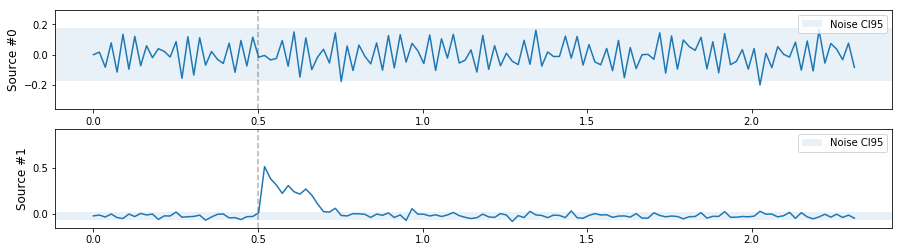

Enter one or more sources number (separate numbers by "," if number of sources > 1): 1


In [7]:
if testing:
    stack_ROIs, label_ROIs, ROIs_means_filtered, time, \
    ROIs_means, ROIs_means_corrected, mask_list, \
    components, selected_source_idx, t_sig_prop, \
    SNR_dB = metroid(fpath,fr_list,transitory,16,16,t_sig_onset,t_sig_end,method,n_comp,wavelet,autoselect)

## Plot results

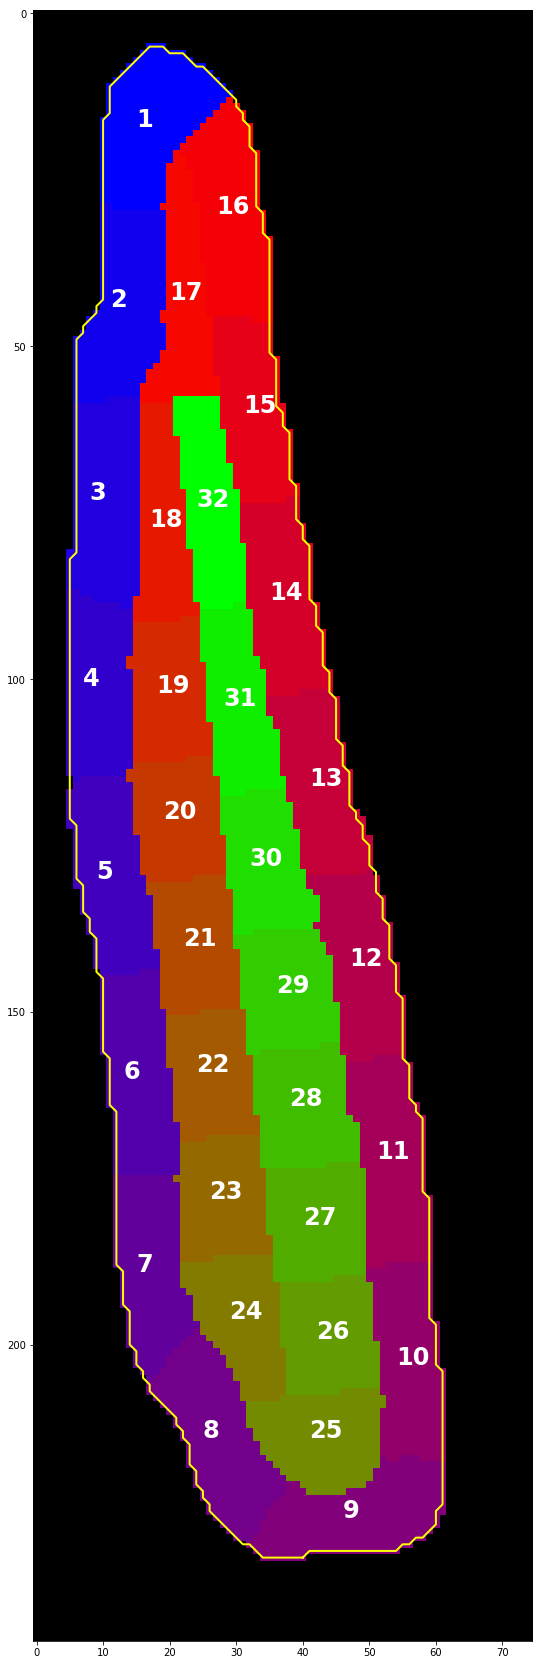

In [8]:
if testing:
    nregions = np.amax(label_ROIs).astype(int)
    ncolors = nregions
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    brg = cm.get_cmap('brg', nregions)
    newcolors = np.tile((np.arange(0,ncolors))/(ncolors-1),nregions//(ncolors-1))
    newcolors = newcolors[:nregions]
    newcolors = brg(newcolors)
    black = np.array([0, 0, 0, 1])
    newcolors = np.insert(newcolors,0,black,axis=0)
    newcmp = ListedColormap(newcolors)
    
    fig, ax = plt.subplots(figsize=[10,30],nrows=1, ncols=1)
    ax.imshow(label_ROIs, cmap=newcmp)

    cent_coord = np.zeros((nregions,2))

    for j in range(nregions):
        cent_coord[j,:] = np.rint(mes.get_centroid(stack_ROIs[j,:,:]))
        ax.annotate(j+1,(cent_coord[j,0]-2,cent_coord[j,1]),xycoords='data',color='white',fontsize=24,weight='bold')
    video_list = get_img_stacks(fpath)
    mask_list = load_masks(video_list, fpath)
    contour = mes.build_contour(mask_list[0])
    ax.plot(contour[:,1],contour[:,0],color='yellow',lw=2)

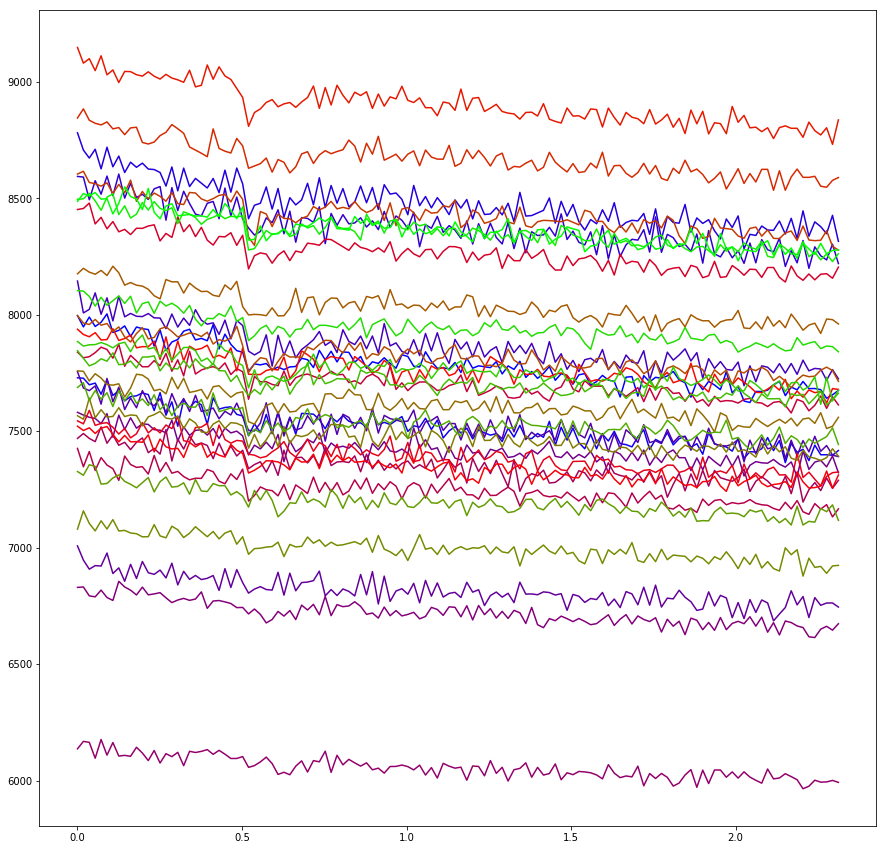

In [9]:
if testing:
    fig, ax1 = plt.subplots(figsize=[15,15])
    for i in range(nregions):
        ax1.plot(time,ROIs_means[:,i],color=newcolors[i+1])

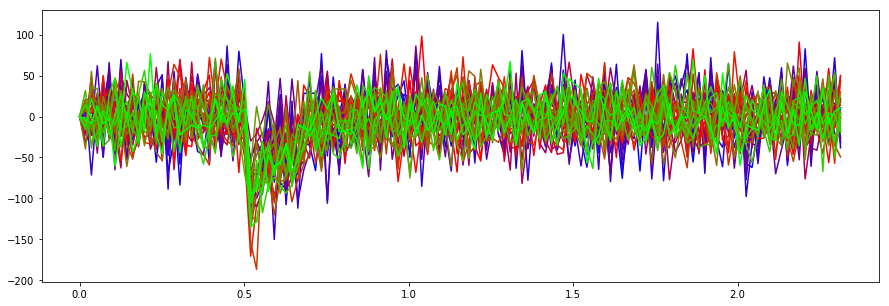

In [10]:
if testing:
    fig, ax1 = plt.subplots(figsize=[15,5])
    for i in range(nregions):
        ax1.plot(time,ROIs_means_corrected[:,i],color=newcolors[i+1])

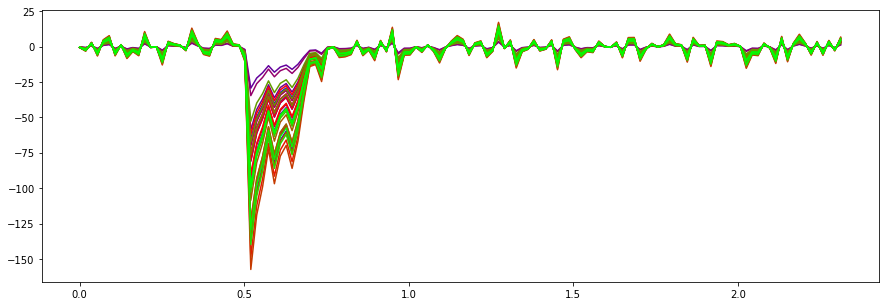

In [11]:
if testing:
    fig, ax1 = plt.subplots(figsize=[15,5])
    for i in range(nregions):
        ax1.plot(time,ROIs_means_filtered[:,i],color=newcolors[i+1])